In [ ]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

In [ ]:
train1 = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
train2 = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')

test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train1, train2, test]).drop(['id'],axis=1)

In [ ]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

In [ ]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")

attack cat: {'Analysis', 'DoS', 'Backdoor', 'Reconnaissance', 'Shellcode', 'Exploits', 'Generic', 'Normal', 'Fuzzers', 'Worms'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int64 Which is, ['Normal']
mode 0.34409972887712637 %


In [ ]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])
combined_data.head(3)

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,6,0


In [ ]:
combined_data_reduced=combined_data

In [ ]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]
# del combined_data # free mem
print(data_x.shape, data_y.shape)

(433014, 42) (433014, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.30, random_state=42) # TODO


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
#import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(data_x,data_y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.01088645 0.00867196 0.02407913 0.03164038 0.00411283 0.0051298
 0.01869137 0.00746232 0.02221634 0.22443603 0.11597486 0.01530545
 0.03921375 0.00502312 0.00861807 0.01577446 0.00737176 0.00778247
 0.00706005 0.03952072 0.01103187 0.01317081 0.026677   0.0112739
 0.01302274 0.01085083 0.0280073  0.02215467 0.00241649 0.0014868
 0.0254818  0.08476213 0.01359007 0.01211431 0.01614942 0.0266744
 0.00049716 0.00059901 0.00249228 0.01314445 0.03195168 0.01347957]


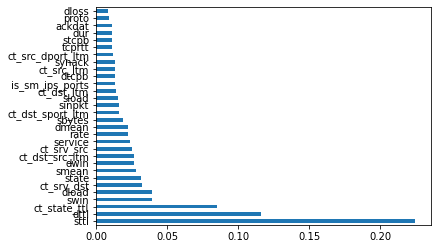

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=data_x.columns)
#feat_importances = pd.Series(model.feature_importances_)
feat_importances.nlargest(30).plot(kind='barh')

In [ ]:
print(feat_importances.nlargest(30))

sttl                0.224436
dttl                0.115975
ct_state_ttl        0.084762
swin                0.039521
dload               0.039214
ct_srv_dst          0.031952
state               0.031640
smean               0.028007
dwin                0.026677
ct_dst_src_ltm      0.026674
ct_srv_src          0.025482
service             0.024079
rate                0.022216
dmean               0.022155
sbytes              0.018691
ct_dst_sport_ltm    0.016149
sinpkt              0.015774
sload               0.015305
ct_dst_ltm          0.013590
is_sm_ips_ports     0.013480
dtcpb               0.013171
ct_src_ltm          0.013144
synack              0.013023
ct_src_dport_ltm    0.012114
tcprtt              0.011274
stcpb               0.011032
dur                 0.010886
ackdat              0.010851
proto               0.008672
dloss               0.008618
dtype: float64


In [ ]:
l=[]
for i in range(30):
    l.append(feat_importances.nlargest(30).index[i])
print(l)

['sttl', 'dttl', 'ct_state_ttl', 'swin', 'dload', 'ct_srv_dst', 'state', 'smean', 'dwin', 'ct_dst_src_ltm', 'ct_srv_src', 'service', 'rate', 'dmean', 'sbytes', 'ct_dst_sport_ltm', 'sinpkt', 'sload', 'ct_dst_ltm', 'is_sm_ips_ports', 'dtcpb', 'ct_src_ltm', 'synack', 'ct_src_dport_ltm', 'tcprtt', 'stcpb', 'dur', 'ackdat', 'proto', 'dloss']


In [ ]:
for i in feat_importances.index:
  if i not in l:
    combined_data_reduced.drop(i, inplace=True,axis=1)

In [ ]:
combined_data_reduced.head()

,dur,proto,service,state,sbytes,rate,sttl,dttl,sload,dload,dloss,sinpkt,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,258,74.087490,252,254,14158.942380,8495.365234,0,24.295600,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,1,0,1,1,1,1,1,1,0,6,0
1,0.649902,113,0,4,734,78.473372,62,252,8395.112305,503571.312500,17,49.915000,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,43,1,1,1,1,2,1,6,0,6,0
2,1.623129,113,0,4,364,14.170161,62,252,1572.271851,60929.230470,6,231.875571,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,7,1,2,1,1,3,2,6,0,6,0
3,1.681642,113,3,4,628,13.677108,62,252,2740.178955,3358.622070,3,152.876547,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,1,1,2,1,1,3,2,1,0,6,0
4,0.449454,113,0,4,534,33.373826,254,252,8561.499023,3987.059814,1,47.750333,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,43,1,2,2,1,40,2,39,0,6,0


In [ ]:
data_x = combined_data_reduced.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.30, random_state=42) # TODO


In [ ]:
X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(303109, 30)

(303109, 1)

(129905, 30)

(129905, 1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
'''
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)
'''

In [ ]:
'''
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
'''

In [ ]:
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
#ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
#XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
#GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500, n_jobs=-1) # multiclass
#DEC = DecisionTreeClassifier(criterion="entropy", max_depth=3)

ttr=0
ppr=0
list_of_CLFs_names = []
list_of_CLFs = [RFC]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))
    y_pred = clf.predict(X_test)
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1 Score: %.3f' % (f1_score(y_test, y_pred)))
    #ttr=y_test
    #ppr=pred
    print('\n\n\n')
    
    list_of_CLFs_names.append(name)




Acc: 0.97537 for the RandomForestClassifier
Precision: 0.977
Recall: 0.986
F1 Score: 0.981






Text(0.5, 1.0, 'training accuracy vs testing accuracy')

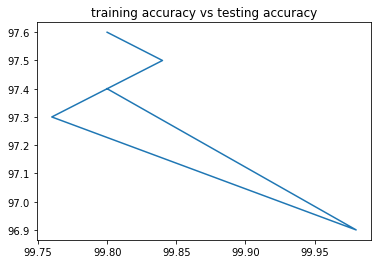

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
x=[99.8, 99.98, 99.76, 99.84, 99.8]
y=[97.4, 96.9, 97.3, 97.5, 97.6]
plt.plot(x, y, '-')

plt.title("training accuracy vs testing accuracy")
plt.show()

Text(0.5, 1.0, 'Precision vs. Recall')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

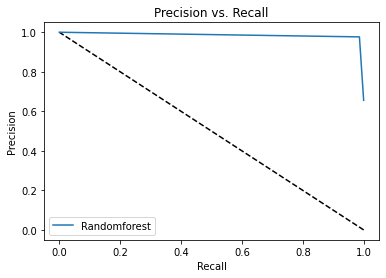

In [ ]:
plt.plot([1, 0], [0, 1], 'k--')

rf_accuracy= round(accuracy_score(y_test, y_pred),3)
rf_prec=round(precision_score(y_test, y_pred),3)
rf_rec=round(recall_score(y_test, y_pred),3)
rf_f1=round(f1_score(y_test, y_pred),3)

from sklearn.metrics import (precision_score, recall_score,f1_score)
from sklearn.metrics import average_precision_score,precision_recall_curve
precision_rf, recall_rf, th_rf = precision_recall_curve(y_test, y_pred)

plt.plot(recall_rf, precision_rf, label='Randomforest')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

Text(0.5, 1.0, 'Precision vs. Recall')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

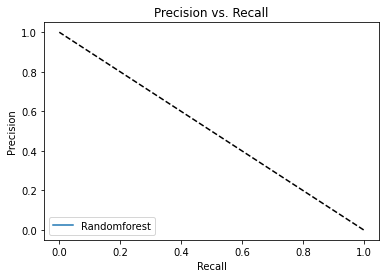

In [ ]:
plt.plot([1, 0], [0, 1], 'k--')

rf_accuracy= round(accuracy_score(y_test, y_pred),3)
rf_prec=round(precision_score(y_test, y_pred),3)
rf_rec=round(recall_score(y_test, y_pred),3)
rf_f1=round(f1_score(y_test, y_pred),3)

from sklearn.metrics import (precision_score, recall_score,f1_score)
from sklearn.metrics import average_precision_score,precision_recall_curve
precision_rf, recall_rf, th_rf = precision_recall_curve(y_test, y_pred)

recall_rf, precision_rf = 0.982, 0.975

plt.plot(recall_rf, precision_rf, label='Randomforest')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import (precision_score, recall_score,f1_score)
from sklearn.metrics import average_precision_score,precision_recall_curve
precision_rf, recall_rf, th_rf = precision_recall_curve(y_test, y_pred)

plt.plot(recall_rf, precision_rf, label='Randomforest')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

Text(0.5, 1.0, 'training accuracy')

(array([1., 2., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([99.76 , 99.782, 99.804, 99.826, 99.848, 99.87 , 99.892, 99.914,
        99.936, 99.958, 99.98 ]),
 <a list of 10 Patch objects>)

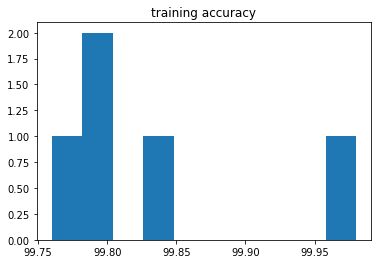

Text(0.5, 1.0, 'testing accuracy')

(array([1., 0., 0., 0., 0., 1., 0., 1., 1., 1.]),
 array([96.9 , 96.97, 97.04, 97.11, 97.18, 97.25, 97.32, 97.39, 97.46,
        97.53, 97.6 ]),
 <a list of 10 Patch objects>)

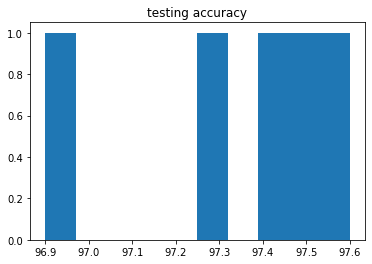

In [ ]:
import matplotlib.pyplot as plt 

values = [99.8, 99.98, 99.76, 99.84, 99.8]
plt.title("training accuracy")
plt.hist(values)
plt.show()

values = [97.4, 96.9, 97.3, 97.5, 97.6]
plt.title("testing accuracy")
plt.hist(values)
plt.show()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


In [ ]:
'''
    y_pred = clf.predict(X_train)
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1 Score: %.3f' % (f1_score(y_test, y_pred)))
    #ttr=y_test
    ranking.append(pred)
    '''

In [ ]:
print('F1 Score: %.3f' % (f1_score(ttr, pred)))

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC
n = 10

In [ ]:
rfe = RFE(DecisionTreeClassifier(), n).fit(X_train, y_train)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE, X_test_RFE = X_train[whitelist], X_test[whitelist]

print('new shape', X_train_RFE.shape) 

for clf in list_of_CLFs:
    _ = clf.fit(X_train_RFE,y_train)
    pred = clf.score(X_test_RFE,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)


eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train_RFE, y_train)
pred = eclf.score(X_test_RFE, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test_RFE)
probas = eclf.predict_proba(X_test_RFE)
plt.show()

new shape (303109, 10)
Acc: 0.89513 for the DecisionTreeClassifier
Acc: 0.97211 for the RandomForestClassifier
Acc: 0.97096 for the ExtraTreesClassifier
Acc: 0.93529 for the XGBClassifier
Acc: 0.95319 for the LGBMClassifier
Acc: 0.96927 for the EnsembleVoteClassifier


In [ ]:
svd = TruncatedSVD(n_components=n).fit(X_train)
X_train_svd, X_test_svd = svd.transform(X_train), svd.transform(X_test)

for clf in list_of_CLFs:
    _ = clf.fit(X_train_svd, y_train)
    pred = clf.score(X_test_svd, y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train_svd, y_train)
pred = eclf.score(X_test_svd, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test_svd)
probas = eclf.predict_proba(X_test_svd)
plt.show()

Acc: 0.91468 for the RandomForestClassifier
Acc: 0.91159 for the ExtraTreesClassifier
Acc: 0.87055 for the XGBClassifier
Acc: 0.90385 for the LGBMClassifier
Acc: 0.91346 for the EnsembleVoteClassifier
